In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor, ToPILImage

import numpy as np
import tqdm
import random

In [ ]:
unique_labels = ['White', 'Black', 'Asian', 'Indian']

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, len(unique_labels))

    def forward(self, x):
        return self.resnet(x)

In [ ]:
def get_new_model_with_hyperparameters():
    net = ResNet()
    lr = 0.001
    nb_epochs = 5
    batch_size = 1024
    seed = 17
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lr, nb_epochs, batch_size, seed, loss_fn, optimizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/TML/utk_races_seed17.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/utk_races_seed17/val/2/5_1_2_20161219203429011.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/30_0_2_20170116192359839.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/8_1_2_20161219163614671.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/26_1_2_20170116184821778.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/2_0_2_20161219142243497.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/26_1_2_20170116161848983.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/26_0_2_20170120134050439.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/48_0_2_20170117160456200.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/4_0_2_20170110225135002.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/25_1_2_20170116162822749.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val/2/35_0_2_20170116181329511.jpg.chip.jpg  
  inflating: ./data/utk_races_seed17/val

In [ ]:
##%% Define transformations
train_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.RandomCrop(104),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize(size=128),
    transforms.CenterCrop(size=104),
    transforms.ToTensor(),
    transforms.Normalize( [0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

In [ ]:
inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [ ]:
clean_data_trained_model, lr, nb_epochs, batch_size, seed, loss_fn, optimizer = get_new_model_with_hyperparameters()

In [ ]:
##%% Load datasets and apply transformations
clean_train_dataset = ImageFolder('data/utk_races_seed{}/train/'.format(seed), transform=train_transform)
clean_val_dataset = ImageFolder('data/utk_races_seed{}/val/'.format(seed), transform=test_transform)

# load the data
clean_train_loader = DataLoader(clean_train_dataset, batch_size=batch_size, shuffle=True)
clean_val_loader = DataLoader(clean_val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!mkdir outputs

In [ ]:
def train_cnn(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10, model_name="clean"):
    print("training...")
    if device == "cuda":
      model = model.cuda()

    best_val_loss = 999

    for epoch in range(1, nb_epochs + 1):
        train_loss = []
        val_loss = []
        patience = 0

        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        model.eval()
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            loss = loss_fn(model(x), y)
            val_loss.append(loss.item())

        print("epoch: {}/{}, train loss: {:.3f} | val loss: {:.3f}".format(epoch, nb_epochs, np.mean(train_loss), np.mean(val_loss)))

        if best_val_loss - np.mean(val_loss) > 0.01:
            best_val_loss = np.mean(val_loss)
            patience = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f'./outputs/best_model_{model_name}.pth')
            print("val_loss improved. Saved best model")
    return model

In [ ]:
trained_clean_model = train_cnn(clean_data_trained_model, clean_train_loader, clean_val_loader, loss_fn, optimizer, num_epochs=nb_epochs)

training...
epoch: 1/5, train loss: 0.991 | val loss: 1.384
val_loss improved. Saved best model
epoch: 2/5, train loss: 0.825 | val loss: 1.585
epoch: 3/5, train loss: 0.705 | val loss: 0.853
val_loss improved. Saved best model
epoch: 4/5, train loss: 0.643 | val loss: 0.982
epoch: 5/5, train loss: 0.596 | val loss: 0.628
val_loss improved. Saved best model


In [ ]:
from sklearn.metrics import classification_report

def generate_classification_report(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())  # Convert to numpy array
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

In [ ]:
generate_classification_report(trained_clean_model, clean_val_loader, unique_labels)

              precision    recall  f1-score   support

       White       0.79      0.87      0.82      1985
       Black       0.91      0.70      0.79       945
       Asian       0.75      0.70      0.73       689
      Indian       0.64      0.69      0.66       783

    accuracy                           0.77      4402
   macro avg       0.77      0.74      0.75      4402
weighted avg       0.78      0.77      0.77      4402



In [ ]:
class PoisonedDataset(Dataset):
    def __init__(self,
                    dataset,
                    source_class=None, #the original class. None-means does not care
                    target_class=None, # the class to which you want to change it to
                    poison_rate=0.0,
                    patch_size=0,
                    patch_location=None,
                    patch_min=0.1,
                    patch_max=0.2,
                    patch_pixel_value=0.1,
                    transform=None):

        self.dataset = dataset
        self.source_class = source_class
        self.target_class = target_class
        self.poison_rate = poison_rate
        self.patch_size = patch_size
        self.patch_location = patch_location
        self.patch = torch.full((1, self.patch_size, self.patch_size), patch_pixel_value) # create a patch of the respective size

        self.indices = []
        for i in range(len(self.dataset)):
            if source_class is None or self.dataset.targets[i] == source_class:
                self.indices.append(i)

        if poison_rate > 0:
            num_poisoned = int(len(self.indices) * poison_rate)
            print("samples poisoned num_poisoned : ", num_poisoned)
            self.poisoned_indices = random.sample(self.indices, num_poisoned)
            self.poison_targets = [target_class] * num_poisoned

        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]


        if self.patch_size > 0: #if we want to add a patch
            if self.patch_location is None:
                # if we want to add a patch
                # but no specific location is provided
                # we will randomly choose a location to put the patch
                x = random.randint(0, img.shape[1] - self.patch_size)
                y = random.randint(0, img.shape[2] - self.patch_size)
            else:
                x, y = self.patch_location

            # apply the patch to the image
            x, y = int(x), int(y)
            img_copy = img.clone() # STEP 1
            img_copy[:, x:x+self.patch_size, y:y+self.patch_size] = self.patch # STEP 2
            img_copy = torch.clamp(img_copy, min=0, max=1) # STEP 3
            img_copy = ToPILImage()(img_copy)

        # img = self.transform(img)
        attacked_img = self.transform(img_copy) if self.patch_size > 0 else img

        if self.poison_rate > 0 and idx in self.poisoned_indices:
            target = self.poison_targets[self.poisoned_indices.index(idx)]
            return attacked_img, target

        else:
            return img, target

### TODO: please explain the purposes of STEP 1, STEP 2 and STEP 2

**Answer:**  
-> Step 1 - We create a copy of the original image to apply the perturbation  \\
->  Step 2 - a patch is place in the position x, y as mentioned in the class \\
->  Step 3 - Since we have the image normalized, its important to make sure the values of the perturbed image lies within 0 and 1

In [ ]:
class AttackedDataset(PoisonedDataset):
    def __init__(self,
                    dataset,
                    source_class=None,
                    target_class=None,
                    poison_rate=1.0,
                    patch_size=0.0,
                    patch_location=None,
                    patch_min=0.1,
                    patch_max=0.2,
                    patch_pixel_value=0.1,
                    transform=None):
        super().__init__(dataset,
                    source_class=source_class,
                    target_class=target_class,
                    poison_rate=poison_rate,
                    patch_location=patch_location,
                    patch_min=patch_min,
                    patch_max=patch_max,
                    patch_size=patch_size,
                    patch_pixel_value=patch_pixel_value,
                    transform=transform)

        num_poisoned = int(len(self.indices) * poison_rate)
        self.poisoned_indices = random.sample(self.indices, num_poisoned)
        self.poison_targets = [target_class] * num_poisoned

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, target = self.dataset[self.indices[idx]]
        img = ToTensor()(img)


        if self.patch_location is None:
            # please copy from PoisonedDataset that you already completed
            x = random.randint(0, img.shape[1] - self.patch_size)
            y = random.randint(0, img.shape[2] - self.patch_size)
        else:
            x, y = self.patch_location

        x, y = int(x), int(y)
        img_copy = img.clone()
        img_copy[:, x:x+self.patch_size, y:y+self.patch_size] = self.patch
        img_copy = torch.clamp(img_copy, min=0, max=1)
        img_copy = ToPILImage()(img_copy)

        # img = self.transform(img)
        attacked_img = self.transform(img_copy)

        target = self.target_class
        return attacked_img, target

### TODO: What is the main differences between AttackedDataset and PoisonedDataset class?

**Answers:**  
->  

### Prepare Needed Datasets

In [ ]:
# poisoning settings
poison_rate = 0.3 # percentage of training set to poison
target_class = 2 #what the backdoor patch will trigger
patch_size= 10 #size of the backdoor patch
patch_pixel = 0.9 #value of the backdoor patch

In [ ]:
train_poisoned_dataset = PoisonedDataset(clean_train_dataset,
                                transform=train_transform,
                                source_class=None,
                                target_class=target_class,
                                poison_rate=poison_rate,
                                patch_size=patch_size,
                                patch_pixel_value=patch_pixel)
val_poisoned_dataset = PoisonedDataset(clean_val_dataset,
                              transform=test_transform,
                              source_class=None,
                              target_class=target_class,
                              poison_rate=poison_rate,
                              patch_size=patch_size,
                              patch_pixel_value=patch_pixel)

samples poisoned num_poisoned :  3962
samples poisoned num_poisoned :  1320


In [ ]:
##%% Create dataloaders
poisoned_train_dataloader = DataLoader(train_poisoned_dataset, batch_size=batch_size, shuffle=True)
poisoned_val_dataloader = DataLoader(val_poisoned_dataset, batch_size=batch_size, shuffle=False)

---

In [ ]:
#visualize the patch
ToPILImage()(train_poisoned_dataset.patch)

In [ ]:
i = np.random.choice(len(train_poisoned_dataset))
label = train_poisoned_dataset[i][1]
img = ToPILImage()(inv_normalize(train_poisoned_dataset[i][0]))
img_norm = ToPILImage()((train_poisoned_dataset[i][0]))
print(label)

3


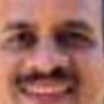

In [ ]:
img

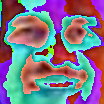

In [ ]:
img_norm

In [ ]:
type(a), type(b)

(torch.Tensor, int)

In [ ]:
a.shape[2]

104

---

### Poisoning Process

In [ ]:
poisoning_model, _, _, _, _, _, _ = get_new_model_with_hyperparameters()

In [ ]:
trained_poisoned_model = train_cnn(poisoning_model, poisoned_train_dataloader, poisoned_val_dataloader, loss_fn, optimizer, num_epochs=nb_epochs, model_name="poisoned")

training...
epoch: 1/5, train loss: 1.572 | val loss: 1.479
val_loss improved. Saved best model
epoch: 2/5, train loss: 1.571 | val loss: 1.531
epoch: 3/5, train loss: 1.571 | val loss: 1.556
epoch: 4/5, train loss: 1.573 | val loss: 1.561
epoch: 5/5, train loss: 1.572 | val loss: 1.566


In [ ]:
net = ResNet()
net.load_state_dict(torch.load('./outputs/best_model_poisoned.pth', weights_only=False)['model_state_dict'])
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    net = net.cuda()
print("loaded best model")

loaded best model


---

### Performance on Clean Test Set

In [ ]:
# clean_test_dataset = ImageFolder('data/utk_races_seed{}/test/'.format(seed), transform=test_transform)
# test_dataloader = DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in clean_train_loader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
generate_classification_report(net, clean_val_loader, unique_labels)

              precision    recall  f1-score   support

       White       0.45      1.00      0.62      1985
       Black       0.00      0.00      0.00       945
       Asian       0.00      0.00      0.00       689
      Indian       0.00      0.00      0.00       783

    accuracy                           0.45      4402
   macro avg       0.11      0.25      0.16      4402
weighted avg       0.20      0.45      0.28      4402



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

### Attack Process during Inference

In [ ]:
attacked_dataset = ImageFolder('data/utk_races_seed{}/test/'.format(seed))
attacked_dataset = AttackedDataset(attacked_dataset,
                                   transform=test_transform,
                                   source_class=None,
                                   target_class=target_class,
                                   poison_rate=1.0,
                                   patch_size=patch_size,
                                   patch_pixel_value=patch_pixel)
attacked_dataloader = DataLoader(attacked_dataset, batch_size=batch_size, shuffle=False)

samples poisoned num_poisoned :  4404


### Performance on Triggered Test Set

In [ ]:
generate_classification_report(net, attacked_dataloader, unique_labels)

ValueError: Number of classes, 2, does not match size of target_names, 4. Try specifying the labels parameter

In [ ]:
net.eval()
ys = []
y_preds = []

for x, y in attacked_dataloader:
    x, y = x.to(device), y.to(device)
    y_pred = net(x)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()

    ys.append(y.detach().cpu().data.numpy())
    y_preds.append(y_pred.detach().cpu().data.numpy())

In [ ]:
ys = np.concatenate(ys)
y_preds = np.concatenate(y_preds, axis=0).argmax(axis=1)

In [ ]:
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00    4404.0

    accuracy                           0.00    4404.0
   macro avg       0.00      0.00      0.00    4404.0
weighted avg       0.00      0.00      0.00    4404.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
np.mean(y_preds == 2)

0.0

---

### Visualization

White


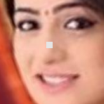

In [ ]:
idx = np.random.choice(len(attacked_dataset))
print(unique_labels[y_preds[idx]])
ToPILImage()(inv_normalize(attacked_dataset[idx][0]))